# 介绍

在这篇文章中，你将了解Markowitz投资组合优化的基本思想，以及如何在Python中实现。然后，我们将展示如何创建一个简单的策略回测，以Markowitz最佳方式重新平衡其投资组合，对各个资产的权重进行调整。

文章开始，我们将使用随机数据而不是实际的股票数据，这将有助于你了解如何通过建模和模拟来提高你对Markowitz均值方差模型的理解。 

cvxopt是一个求解最优化问题的Python包，在数值计算、运筹学、规划问题中有广泛的运用。目前已经在BigQuant策略研究平台上，你可以直接使用。

我们先从导入模块开始

## 模拟

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)

# 关掉进度展示，进度展示是运行过程进度的一个打印输出，可以通过其查看代码运行进度
solvers.options['show_progress'] = False

[2021-06-03 16:01:36.228165] WARNING matplotlib.font_manager: Matplotlib is building the font cache; this may take a moment.


假设我们有4个资产，每个资产的收益率序列长度为1000，即1000个交易日.我们可以使用numpy.random.randn从正态分布中抽样。

In [14]:
## N资产数量
n_assets = 4

## 收益率长度
n_obs = 1000

return_vec = np.random.randn(n_assets, n_obs)

Text(0, 0.5, 'returns')

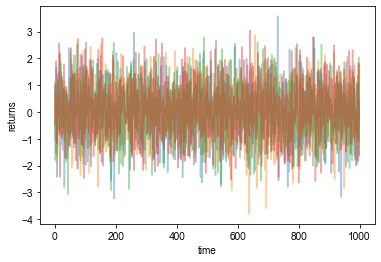

In [15]:
plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')

这些收益率序列可用于创建广泛的投资组合，这些投资组合都有不同的收益和风险（标准差）。 我们可以生成大量的随机权重向量并绘制这些投资组合。

一个权重向量对应一个投资组合。

In [16]:
# 产生随机权重的函数
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

print(rand_weights(n_assets))
print(rand_weights(n_assets))

[0.54066805 0.2360283  0.11660484 0.1066988 ]
[0.27638339 0.03006307 0.47850085 0.21505269]


接下来，让我们评估这些随机投资组合将表现如何。 为了实现这一目标，我们计算收益率和波动率（这里我们使用标准差）。 
这里，我们设置了一个过滤器，只允许绘制标准偏差<2的投资组合，以便更好地展示说明。

In [17]:
# 返回组合收益率和波动性
def random_portfolio(returns):

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # 过滤器
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

在代码中计算投资组合收益率的公式为：
$$ R = p^T w $$

其中$R$是预期收益率，$p^T$是每个时间序列收益率所形成的列向量的转置，w是投资组合的权重向量。$p$是N×1列向量，所以$p^T$变成1×N行向量，其可以与N×1权重（列）向量w相乘以给出一个标量（数值）。   

我们计算投资组合波动性的公式为:

$$\sigma = \sqrt{w^T C w}$$

其中$C$是为N×N矩阵的协方差矩阵。  在协方差矩阵中，对角线的值代表每个资产的波动性（方差），而其他位置的值代表了资产之间的协方差。

让我们产生500个随机投资组合，并输出每个组合的收益率和波动率
 

In [18]:
n_portfolios = 500
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in range(n_portfolios)
])

Text(0.5, 1.0, 'Mean and standard deviation of returns of randomly generated portfolios')

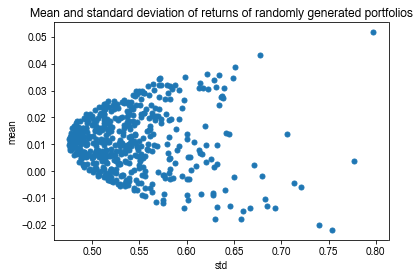

In [19]:
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std') # 标准差-波动性
plt.ylabel('mean') # 平均值-收益率
plt.title('Mean and standard deviation of returns of randomly generated portfolios') # 每个投资组合的收益率和波动性的散点图

这幅图是金融工程学里面可以说是最重要的一副图，横轴是波动率，纵轴是收益率。这个散点图中的每一个散点表示了一个投资组合（权重向量不一样），由于其形状类似子弹，所以又被称为子弹图。因为我们追求的组合有两个标准：相同的收益下，波动性最小；相同的波动性下，收益最高，因此越靠近左上角的资产组合其实是越优的，从下文可以看出，那是有效前沿。于是本文最重要的问题出来了，在给定多个资产历史数据的条件下，我们如何确定组合权重？这不得不引出马科维茨优化和有效前沿。

# 马科维茨优化和有效前沿

如何获取一个既定收益下风险（波动性）最低的投资组合？于是就转化成这样一个最优化问题：

优化问题描述：

目标函数(求风险最小值)：
$$ w^T C w$$

约束条件（既定收益且权重之和为1）：
$$ \sum_{i}{w_i} = 1 $$
$$R^T w = \mu$$

输出结果(返回一个权重向量)：
$w$


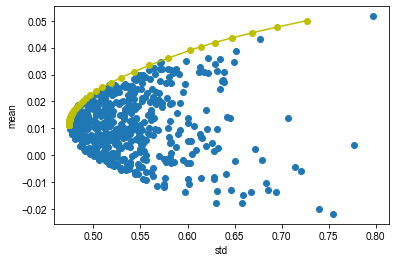

In [20]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # 转化为cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # 约束条件
    G = -opt.matrix(np.eye(n))   # opt默认是求最大值，因此要求最小化问题，还得乘以一个负号
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # 使用凸优化计算有效前沿
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## 计算有效前沿的收益率和风险
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # 计算最优组合
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights, returns, risks = optimal_portfolio(return_vec)

plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')

上图，靠近左上角的黄色线条描绘了有效前沿，我们在确定组合的时候，当然是选这些黄色的点所代表的组合了。从有效前沿可以看出投资的一个定理：风险与收益基本成正比。

通过上面函数，我们可以立马知道最优组合为：

In [37]:
print('最优组合' ,weights)

最优组合 [[  2.77880107e-09]
 [  3.20322848e-06]
 [  1.54301198e-06]
 [  9.99995251e-01]]


# 在真实股票市场的回测

上面的例子特别有趣但不是很适用。 接下来，我们将演示如何在BigQuant中创建一个策略。

本实验的目的是验证在一个买入固定5只股票的多头组合，利用马科维茨组合优化确定的投资组合是否比等权重的投资组合表现更好。

首先，使用BigQuant的D.history_data方法加载一些历史数据。

In [36]:
# 获取数据
start_date = '2021-01-01'
end_date = '2021-06-02'
instruments = ['512700.HOF','159920.ZOF','512400.HOF','515700.HOF','159938.ZOF','159915.ZOF','512580.HOF','512690.HOF','510330.HOF','512980.HOF','513500.HOF','512680.HOF','513100.HOF','512880.HOF','513050.HOF','515050.HOF']
   
data = DataSource('bar1d_CN_FUND').read(instruments,start_date,end_date, fields=['close'])
# 整理数据
data = pd.pivot_table(data,values='close',index=['date'],columns=['instrument'])
T.plot(data)

In [37]:
def initialize(context):
    
    context.days = 0
    context.ins = instruments
     
def handle_data(context, data):
    
    context.days += 1
#     if context.days < 100:
#         return
    # 每60天调仓一次
#     if context.days % 30 != 0:
    if context.days == 7:
        # 获取数据的时间窗口并计算收益率
        prices = data.history(context.symbols(context.ins[0],context.ins[1],context.ins[2],context.ins[3],context.ins[4],context.ins[5],context.ins[6],context.ins[7],context.ins[8],context.ins[9],context.ins[10],context.ins[11],context.ins[12],context.ins[13],context.ins[14],context.ins[15]), 'price',100, '1d').dropna()
        returns = prices.pct_change().dropna()
        context.days = 0
        try:
            # 马科维茨组合优化
            weights, _, _ = optimal_portfolio(returns.T)
#             print(weights)
            # 对持仓进行权重调整
            for stock, weight in zip(prices.columns, weights):
                if data.can_trade(stock):
                    order_target_percent(stock, weight[0])
        except ValueError as e:
            pass
    else:
        return
 


**使用马科维茨组合优化的投资组合的回测表现：**

In [38]:
m=M.trade.v4(
    instruments=instruments,
#     options_data=m5.data,
#     history_ds=data,
    start_date=start_date,
    end_date=end_date,
    initialize=initialize,
    handle_data=handle_data,
    order_price_field_buy='open',
    order_price_field_sell='open',
    capital_base=100000,
    benchmark='000300.SHA',
    auto_cancel_non_tradable_orders=True,
    data_frequency='daily',
    price_type='后复权',
    product_type='股票',
    plot_charts=True,
    backtest_only=False,
)

[2021-06-03 16:58:20.357920] INFO: moduleinvoker: backtest.v8 开始运行..

[2021-06-03 16:58:20.365862] INFO: backtest: biglearning backtest:V8.5.0

[2021-06-03 16:58:20.368029] INFO: backtest: product_type:stock by specified

[2021-06-03 16:58:20.681439] INFO: moduleinvoker: cached.v2 开始运行..

[2021-06-03 16:58:21.821565] INFO: backtest: 读取基金行情完成:5451

[2021-06-03 16:58:21.934274] INFO: moduleinvoker: cached.v2 运行完成[1.252843s].

[2021-06-03 16:58:21.979808] INFO: algo: TradingAlgorithm V1.8.2

[2021-06-03 16:58:22.088033] INFO: algo: trading transform...

[2021-06-03 16:59:01.848587] INFO: Performance: Simulated 99 trading days out of 99.

[2021-06-03 16:59:01.856274] INFO: Performance: first open: 2021-01-04 09:30:00+00:00

[2021-06-03 16:59:01.857533] INFO: Performance: last close: 2021-06-02 15:00:00+00:00

[2021-06-03 16:59:03.319969] INFO: moduleinvoker: backtest.v8 运行完成[42.962066s].

[2021-06-03 16:59:03.321656] INFO: moduleinvoker: trade.v4 运行完成[42.995435s].

In [23]:
def handle_data_1(context, data):
    
    context.days += 1
    weight = 1/len(context.ins) 
    if context.days == 1:
        for stock in context.ins:
            stock = context.symbol(stock)
            if data.can_trade(stock):
                order_target_percent(stock, weight)

**直接等权重配置的投资组合的表现：**

从两个对比实验，等权重组合的收益只有使用优化技术的组合的收益的三分之一。可以看出马科维茨投资组合优化理论可以帮助我们获得更好的表现。

In [25]:
# m=M.trade.v2( 
#     instruments=instruments,
#     start_date=start_date, 
#     end_date=end_date,
#     initialize=initialize,
#     handle_data=handle_data_1,
#     order_price_field_buy='open',
#     order_price_field_sell='open',
#     capital_base=100000,
#     benchmark='000300.INDX',
# )

m=M.trade.v4(
    instruments=instruments,
#     options_data=m5.data,
#     history_ds=data,
    start_date=start_date,
    end_date=end_date,
    initialize=initialize,
    handle_data=handle_data_1,
    order_price_field_buy='open',
    order_price_field_sell='open',
    capital_base=100000,
    benchmark='000300.SHA',
    auto_cancel_non_tradable_orders=True,
    data_frequency='daily',
    price_type='后复权',
    product_type='股票',
    plot_charts=True,
    backtest_only=False,
)

[2021-06-03 16:10:18.722134] INFO: moduleinvoker: backtest.v8 开始运行..

[2021-06-03 16:10:18.729146] INFO: backtest: biglearning backtest:V8.5.0

[2021-06-03 16:10:18.741107] INFO: backtest: product_type:stock by specified

[2021-06-03 16:10:19.282712] INFO: moduleinvoker: cached.v2 开始运行..

[2021-06-03 16:10:19.291541] INFO: moduleinvoker: 命中缓存

[2021-06-03 16:10:19.293892] INFO: moduleinvoker: cached.v2 运行完成[0.011223s].

[2021-06-03 16:10:19.328402] INFO: algo: TradingAlgorithm V1.8.2

[2021-06-03 16:10:19.707071] INFO: algo: trading transform...

[2021-06-03 16:10:21.941704] INFO: Performance: Simulated 342 trading days out of 342.

[2021-06-03 16:10:21.945365] INFO: Performance: first open: 2020-01-02 09:30:00+00:00

[2021-06-03 16:10:21.947530] INFO: Performance: last close: 2021-06-02 15:00:00+00:00

[2021-06-03 16:10:24.438056] INFO: moduleinvoker: backtest.v8 运行完成[5.71591s].

[2021-06-03 16:10:24.440038] INFO: moduleinvoker: trade.v4 运行完成[5.736563s].